## Exploratory Data Analysis of the Santander III Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

### Load the data set

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

After check, min value of the whole dataframe is 0.
Only `ID` is object, all other columns are numerical.

In [3]:
print('train set shape: {}'.format(train.shape))
print('test set shape: {}'.format(test.shape))

train set shape: (4459, 4993)
test set shape: (49342, 4992)


#### simple histogram of any selected columns

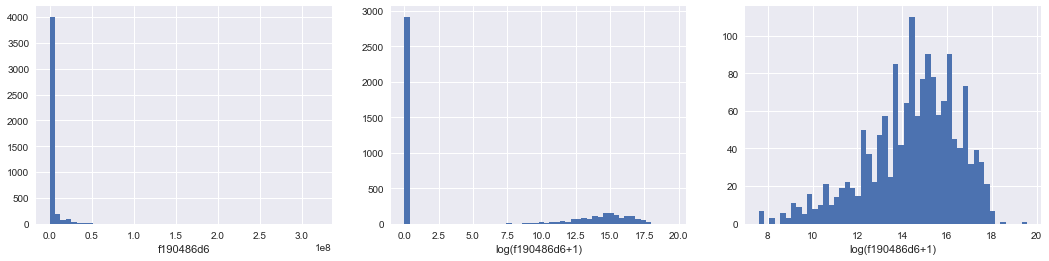

In [4]:
col = np.random.randint(low=2, high=4993, size=1)
col = train.columns.values[col][0]
#col = 'c5a231d81'
col = 'f190486d6'
#col = 'target'
plt.figure(figsize=(18,4))
plt.subplot(131, xlabel=col)
train[col].hist(bins=50)
plt.subplot(132, xlabel='log('+col+'+1)')
np.log(train.loc[:,col]+1).hist(bins=50)
plt.subplot(133, xlabel='log('+col+'+1)')
np.log(train.loc[train[col]!=0,col]+1).hist(bins=50) # impute zero
plt.show()

### Calculate statistics

#### custom code for Information Value

In [6]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

max_bin = 20
force_bin = 5

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

#### column stats, such as mean, min, max, median, count, missingrate, skewness, kurtosis, uniquecount

In [7]:
def ColumnStats(df, target='TARGET', exclude=[], regression=False, na_values=[]):
    cols = list(set(df.columns.values) - set(exclude) - set([target]))
    df.replace(0, np.nan, inplace=True)
    if na_values:
        df_stats = df[cols].describe(percentiles=[0.5]).transpose().reset_index().rename(columns={'index':'columnName', '50%':'median', 'count':'totalCnt'})
    else:
        df_stats = df[cols].describe(percentiles=[0.5]).transpose().reset_index().rename(columns={'index':'columnName', '50%':'median', 'count':'totalCnt'})
    df_stats['missingRate'] = 1.0 - df_stats['totalCnt'] / df.shape[0] 
    df_stats['skewness'] = df[cols].skew().values
    df_stats['kurtosis'] = df[cols].kurtosis().values
    df_stats['uniqueCnt'] = df[cols].nunique(dropna=True).values
    
    if not regression:
        final_iv, df_iv = data_vars(df[cols],df[target])
        df_iv.rename(columns={'VAR_NAME':'columnName'}, inplace=True)
        df_stats = df_stats.merge(df_iv, on='columnName', how='left')
    return df_stats

In [8]:
df_stats = ColumnStats(pd.concat([train,test]), target='target', exclude=['ID'], regression=True, na_values=[0])

In [9]:
df_stats[df_stats.uniqueCnt>2].sort_values(by=['missingRate'], ascending=False).head(10)

,columnName,totalCnt,mean,std,min,median,max,missingRate,skewness,kurtosis,uniqueCnt
842,f416800e9,162.0,1.838612e+07,3.641569e+07,3387.676294,4.011743e+06,2.138927e+08,0.996989,3.269710,11.482903,161
4597,5a1183b8c,170.0,1.380166e+07,2.896057e+07,1047.748652,4.113643e+06,2.380439e+08,0.996840,4.494104,25.888488,170
3424,73a32cd05,171.0,1.749587e+07,3.969564e+07,635.233153,4.669647e+06,3.305519e+08,0.996822,5.105378,32.056128,170
3417,ac2e428a9,173.0,1.806603e+07,4.210079e+07,340.222678,4.886962e+06,4.088735e+08,0.996784,5.891364,45.935694,173
3127,770d3a11c,173.0,1.974573e+07,3.841030e+07,963.585502,3.794171e+06,2.909470e+08,0.996784,3.691740,17.879602,173
419,ae82c2c99,174.0,1.706296e+07,3.878872e+07,209.906123,4.098667e+06,2.884592e+08,0.996766,4.622652,24.765908,174
3175,d0e4129cb,175.0,1.470622e+07,3.521705e+07,342.226468,3.966839e+06,3.038120e+08,0.996747,5.552527,36.815661,174
1256,1b6c8debf,176.0,1.487451e+07,3.137502e+07,1011.109223,3.472173e+06,3.059394e+08,0.996729,5.453962,42.964591,173
4652,969d32625,176.0,2.438392e+07,7.036363e+07,1557.733095,3.943271e+06,5.863988e+08,0.996729,5.479486,33.941188,174
4919,9c740daca,176.0,1.506838e+07,2.738339e+07,5199.945361,5.457390e+06,2.001947e+08,0.996729,3.676396,16.713897,176


#### Check high missingRate volumn

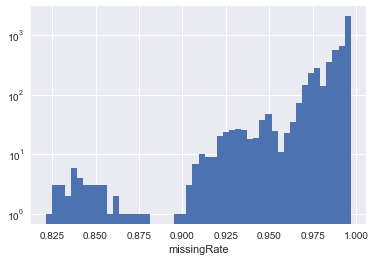

In [38]:
p = df_stats.missingRate.hist(bins=50)
plt.xlabel('missingRate')
plt.yscale('log')

In [19]:
cols_high_misRate = df_stats.loc[df_stats.missingRate>=0.996, 'columnName'].tolist()
print('number of high missingRate features : {}'.format(len(cols_high_misRate)))

number of high missingRate features : 687


#### Columns with only constant zero, will be removed from the feature list

In [25]:
cols_cnst = df_stats.loc[df_stats.uniqueCnt==1, 'columnName'].tolist()
print('number of constant features : {}'.format(len(cols_cnst)))

number of constant features : 0


#### Check how many columns are exact duplicates except constant zero columns

Although only around half of the "constant" features in train also belongs to high missingrate features in col_high_misRate, these features might need to be excluded due to the fact that we cannot learn useful informations from these features.

In [36]:
is_dup_t_f = train.loc[:,~train.columns.isin(cols_cnst)].T.duplicated()
cols_dup = train.loc[:,~train.columns.isin(cols_cnst)].columns[is_dup_t_f].tolist()
print('number of duplicated columns in train set (including constant features : {}'.format(len(cols_dup)))

number of duplicated columns in train set (including constant features : 260


#### Identify Highly Correlated Features

In [39]:
# Create correlation matrix
all_df = pd.concat([train.drop(['target'],axis=1), test])
corr_matrix = all_df.drop(['ID'], axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

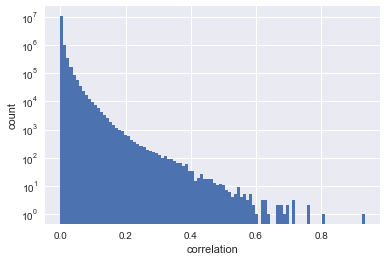

In [40]:
upper_array = upper.values.reshape(1,-1)
plt.hist(upper_array[~np.isnan(upper_array)], bins=100)
plt.yscale('log')
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()

Find index of feature columns with correlation greater than 0.99

In [58]:
cols_high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]
print('features drop due to high correlations : {}'.format(len(cols_high_corr)))

features drop due to high correlations : 1


Examine highly correlated row-column pairs

In [48]:
to_drop_pairs = pd.DataFrame([(upper.index[i], upper.columns[j], upper.iloc[i,j]) for i, j in np.argwhere(upper.fillna(0).values > 0.9)],
                             columns=['row', 'column', 'correlation']).sort_values(by=['correlation'], ascending=False)

In [49]:
to_drop_pairs.head()

,row,column,correlation
0,2f7b3364a,bf8150471,0.933257


0 2f7b3364a bf8150471 0.9332572076017851


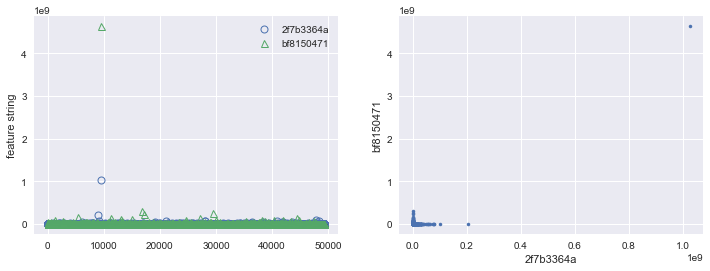

In [57]:
import random
ind = random.randint(0, to_drop_pairs.shape[0]-1)
row, col, corr = to_drop_pairs.iloc[ind, :]
print(ind, row, col, corr)
plt.figure(figsize=(12,4))
plt.subplot(121, ylabel='feature string')
plt.plot(all_df[row], 'o', markerfacecolor='None', markeredgewidth=1, label=row)
plt.plot(all_df[col], '^', markerfacecolor='None', markeredgewidth=1, label=col)
plt.legend(loc='best')
plt.subplot(122, xlabel=row, ylabel=col)
plt.plot(all_df[row], all_df[col], '.')
plt.show()

#### Calculate PSI for train vs test set

For description of concept : http://ucanalytics.com/blogs/population-stability-index-psi-banking-case-study/

For code implementation : https://github.com/mwburke/population-stability-index

In [59]:
from psi import calculate_psi
def calc_psi(train_col, test_col, buckettype='quantiles', buckets=20):
    uniqueCnt = pd.concat([train_col, test_col]).nunique()
    buckets = np.min([uniqueCnt, buckets])
    psi = calculate_psi(train_col, test_col, buckettype=buckettype, buckets=buckets, axis=1)
    return psi

In [60]:
df_stats['PSI'] = df_stats.columnName.apply(lambda x: calc_psi(train[x], test[x]))

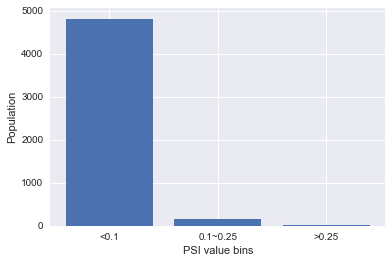

In [61]:
cnts, breakpoints = np.histogram(df_stats.PSI, [0, 0.1, 0.25, np.infty])
plt.bar(range(len(cnts)), cnts)
plt.xticks(range(len(cnts)), ['<0.1', '0.1~0.25', '>0.25'])
plt.xlabel('PSI value bins')
plt.ylabel('Population')
plt.show()

In [62]:
cols_high_psi = df_stats.loc[df_stats.PSI>0.1, 'columnName'].tolist()
print('features drop due to high PSI : {}'.format(len(cols_high_psi)))

features drop due to high PSI : 178


#### Calculate KS (Kolmogorov–Smirnov) for train vs test set

In [63]:
from scipy.stats import ks_2samp
def calc_ks(train_col, test_col):
    ks, pvalue = ks_2samp(train_col.values, test_col.values)
    return (ks, pvalue)

In [64]:
df_stats[['KS', 'KS_Pvalue']] = pd.DataFrame.from_records(df_stats.columnName.apply(lambda x: calc_ks(train[x], test[x])).tolist())

In [65]:
KS_diff_cols = []
for col in df_stats.columnName:
    ks_stat = df_stats.loc[df_stats.columnName==col, 'KS'].values[0]
    pvalue = df_stats.loc[df_stats.columnName==col, 'KS_Pvalue'].values[0]
    if  pvalue <= 0.05 and np.abs(ks_stat) > 0.1:
        KS_diff_cols.append({'columnName': col, 'KS': np.round(np.abs(ks_stat), 2), 'KS_Pvalue': np.round(pvalue, 5)})
KS_diff_df = pd.DataFrame(KS_diff_cols).sort_values(by='KS', ascending=False)
print('number of colmns with high KS : {}'.format(KS_diff_df.shape[0]))
KS_diff_df.head()

number of colmns with high KS : 150


,KS,KS_Pvalue,columnName
84,0.27,0.0,0ff32eb98
64,0.25,0.0,c5a231d81
33,0.24,0.0,c47340d97
121,0.24,0.0,adb64ff71
130,0.23,0.0,190db8488


### Summarize to drop features and dump to file

In [72]:
to_drop = list(set(cols_high_misRate) | set(cols_cnst) | set(cols_high_corr))
print("number of features to drop : {}".format(len(to_drop)))


number of features to drop : 688


In [73]:
out_file = open('../output/columns/forceremove.column.names', 'w')
for var in to_drop:
    out_file.write("%s\n" % var)
out_file.close()

### Check with Model top variables

In [71]:
df_stats[df_stats.columnName.isin(['f190486d6', 'eeb9cd3aa', '58e2e02e6', '9fd594eec', '15ace8c9f', 'b43a7cfd5', '491b9ee45', '6eef030c1', '024c577b9', '1702b5bf0', '20aa07010', '58232a6fb', 'f74e8f13d', 'd6bb78916', 'fb0f5dbfe', '58e056e12', 'c5a231d81', '64e483341', '45f6d00da', 'f8b733d3f'])]

,columnName,totalCnt,mean,std,min,median,max,missingRate,skewness,kurtosis,uniqueCnt,PSI,KS,KS_Pvalue
371,eeb9cd3aa,9298.0,9.023746e+06,1.568020e+07,148.100438,3.000000e+06,3.367845e+08,0.827178,5.277508,60.267518,2646,1.598322e-01,0.181475,7.496841e-118
682,f74e8f13d,8413.0,8.696299e+06,1.491496e+07,51.636933,2.780000e+06,3.779308e+08,0.843627,4.991567,63.459346,2449,1.979558e-01,0.194969,5.791170e-136
971,b43a7cfd5,8695.0,9.241614e+06,1.600563e+07,501.261062,3.000000e+06,3.436712e+08,0.838386,5.159771,58.623665,2571,1.694327e-01,0.175520,2.855974e-110
996,491b9ee45,7883.0,9.162406e+06,1.857852e+07,213.676001,2.848000e+06,8.656981e+08,0.853479,15.728182,603.373781,2345,2.309738e-01,0.212741,8.456947e-162
1070,f190486d6,9595.0,8.705141e+06,1.442387e+07,319.622360,2.906996e+06,3.196120e+08,0.821658,4.248919,40.611344,2718,1.547018e-01,0.183180,4.557184e-120
1097,fb0f5dbfe,9030.0,8.947227e+06,1.512078e+07,952.430314,3.000000e+06,3.196120e+08,0.832159,4.720525,47.623911,2581,1.657984e-01,0.182628,2.389075e-119
1217,20aa07010,8958.0,9.025211e+06,1.545493e+07,8.215890,3.000000e+06,3.435658e+08,0.833498,5.605095,76.792672,2595,1.691527e-01,0.183883,5.468869e-121
1438,1702b5bf0,8734.0,9.135415e+06,1.568652e+07,508.472742,3.000000e+06,3.869182e+08,0.837661,5.357410,69.881101,2553,1.854329e-01,0.189911,5.068695e-129
2145,c5a231d81,6417.0,8.745982e+06,1.730561e+07,410.254916,2.649000e+06,4.673775e+08,0.880727,8.632352,155.851150,2146,4.155492e-01,0.252702,4.062619e-228
2560,6eef030c1,9106.0,9.028521e+06,1.559269e+07,261.378184,3.011500e+06,3.433333e+08,0.830747,4.600881,43.655893,2595,1.512744e-01,0.171327,4.375911e-105
